# Participants’ agreement and some effects of design expertise, fluency, and nativity

- Gwet AC1 (2014) is used to measure inter-participants’ agreement
- the experiment is interpreted as an annotation task where participants (coders) annotate each triplets using single characters as labels
- hypothesis tests are run to compare distributions of OOOO frequencies between scripts and between different groups divided based on expertise, fluency, and nativity

In [1]:
# intro, defaults (shared across notebooks)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pingouin as pg
from irrCAC.raw import CAC
import scipy.stats as st

# ---------------------------------------------------
# set global properties for plotting

font = {"family":"Adapter Mono PE", "size":"10", "weight":"medium"}
figure = {"titlesize":"10","titleweight":"medium"}
axes = {"titlesize":"10", "titleweight":"medium", "labelsize":"10", "labelweight":"medium"}
plt.rc("font", **font)
plt.rc("figure", **figure)
plt.rc("axes", **axes)
COL = "black"
box_colors = dict(boxes=COL, whiskers=COL, medians=COL, caps=COL)

# ---------------------------------------------------
# Fisher’s Exact test via R

from rpy2.robjects import pandas2ri
from rpy2.robjects.packages import importr
# activate the Pandas conversion of rpy2
pandas2ri.activate()
# import stats package
rstats = importr("stats")

def fisher_exact(counts, columns=["T1", "T2"]):
    """
    (Using R via rpy2. See the imports above.)
    
    Performs Fisher’s exact test for testing the null of independence
    of rows and columns in a contingency table with fixed marginals.
    
    Input:  df - DataFrame 2x3
    Output: p_val - p-value of the test
    """

    def scale(counts, total):
        """
        Scale the counts to fit the total provided.
        Avoid rounding errors.
        """
        
        counts = counts / counts.sum() * total
        counts = counts.round()
        counts.iloc[2] = total - (counts.iloc[0] + counts.iloc[1])
        return counts

    # scale counts with the smaller total to the larger total
    nc = counts.copy()
    total1 = nc[columns[0]].sum()
    total2 = nc[columns[1]].sum()
    if total1 < total2:
        nc[columns[0]] = scale(nc[columns[0]], total2)
    elif total1 > total2:
        nc[columns[1]] = scale(nc[columns[1]], total1)
    
    # perform Fisher’s test
    res = rstats.fisher_test(counts)
    p_val = res.rx("p.value")[0][0]
    return nc, p_val

In [2]:
# Get data & fix types

# Tall data (a single response per row)
data = pd.read_csv("csv/raw-data-preprocessed_tall.csv", index_col=0, header=0, dtype="unicode")
data.sort_index(axis=1, inplace=True)
data["pid"] = data["pid"].astype("int")
data["order"] = data["order"].astype("float").astype("int")
#data["response"] = data["response"].astype("category")
data["fluent in script"] = (data["fluent in script"] == "True").astype("category")
data["native in script"] = (data["native in script"] == "True").astype("category")

# Wide data (all participant responses per row, lots of NA)
data_wide = pd.read_csv("csv/raw-data-preprocessed.csv", index_col=0, header=[0,1,2], dtype="unicode")
data_wide.sort_index(axis=1, inplace=True)
data_wide[("control", "control", "order")] = data_wide[("control", "control", "order")].astype("float").astype("int")
data_wide[("control", "control", "fluent in script")] = (data_wide[("control", "control", "fluent in script")] == "True").astype("category")
data_wide[("control", "control", "native in script")] = (data_wide[("control", "control", "native in script")] == "True").astype("category")

SCRIPTS = ["cyrillic", "devanagari", "latin"]
DESIGNERS = ["Graphic designer", "Other designer", "Typographer", "Letter designer"]
TYPEFACES = {script: sorted(data[data["script"] == script]["typeface"].drop_duplicates().values) for script in SCRIPTS}
CHARS = sorted(data["response"].drop_duplicates().values)

In [3]:
#display(data)
pcount = len(data[data["order"] == 1]) // 56
scount = len(data) // 56
print(f"Tall: imported {data.shape[0]} rows, {data.shape[1]} columns, {pcount} participants, {scount} sessions, 56 trial responses each.")

Tall: imported 100072 rows, 14 columns, 1721 participants, 1787 sessions, 56 trial responses each.


In [4]:
# Design expertise: describe individual groups

MIN_RESPONSE_TOTAL = 5  # minimal total response counts per group is 5
MIN_TRIALS = 10  # minimal number of shared trials is 10, has to be bigger than 2 for the sake of correlation tests
COLS = [  # to get a nice order in the result reports
  "Script",
  "Group",
  "Groups compared",
  "Participants",
  "Trials",
  "OOOO",
  "OOOO %",
  "OOOO MWU",
  "OOOO MWU (p)",
  "OOOO MWU (CLES)",
  "Spearman",
  "Gwet",
  "FET in % (n)",
  "Spearman p",
  "Gwet p",
  "Response total (mean)",
  "Test1",
  "Test2",
]

def format_small(p, p_val=False):
  """
  Format p-value
  """
  if p_val:
    if p < 0.001:
      return "<.001"
    elif p > 0.999:
      return "1.000"
    else:
      return f"{p:.3f}"[1:]
  else:
    if p > 0.999:
      return "1.00"
    else:
      return f"{p:.2f}"[1:]

def subset_data(data, groupby, values, script, wide=False):
  """
  Apply conditions to subset the main data
  """

  # wide data use different column index
  if wide:
    GROUPBY = ("control", "control", groupby)
    ORDER = ("control", "control", "order")
    SCRIPT = ("control", "control", "script")
  else:
    GROUPBY = groupby
    ORDER = "order"
    SCRIPT = "script"

  # for background/demography-based analysis, using only order=1
  condition = (data[SCRIPT] == script) & (data[ORDER] == 1)
  for i, v in enumerate(values):
    if isinstance(v, (list, tuple)):
      yield data[condition & (data[GROUPBY].isin(v))]
    else:
      yield data[condition & (data[GROUPBY] == v)]

results = []
for script in SCRIPTS:
  # get data for different groups
  for groupby, value in [
    ("design skills", "Non-designer"),
    ("design skills", "Other designer"),
    ("design skills", "Graphic designer"),
    ("design skills", "Typographer"),
    ("design skills", "Letter designer"),
    ("design skills", DESIGNERS),
  ]:
    row_results = {}
    # subset the wide dataset
    adata = pd.DataFrame(*subset_data(data_wide, groupby, [value], script, wide=True))
    # filter out unnecessary columns, incl. control
    adata = adata[script].dropna(how="all")

    if len(adata.columns) >= MIN_TRIALS and len(adata.index) >= MIN_RESPONSE_TOTAL:
    
      # Mean total response count across both groups
      total_mean = adata.count().mean()

      # Gwet AC1
      # format the reliability data
      for c in adata.columns:
        adata[c] = [np.nan if pd.isnull(v) else CHARS.index(v) for v in adata[c].values]
      raters = CAC(adata.T)
      gwet = raters.gwet()["est"]["coefficient_value"]
      gwet_p = raters.gwet()["est"]["p_value"]

      row_results = {
        "Response total (mean)": f"{total_mean:.1f}",
        "Gwet":  format_small(gwet),
        "Gwet p":  format_small(gwet_p, p_val=True),
      }
    # format results
    if groupby.startswith("fluent"):
      group_nice = "Fluent" if value else "Non-fluent"
    elif groupby.startswith("native"):
      group_nice = "Native" if value else "Non-native"
    elif groupby.startswith("design"):
      if value == DESIGNERS:
        group_nice = "All designers"
      # elif value == NON_DESIGNERS:
      #   group_nice = "Non-designers"
      # elif value == LETTER_DESIGNERS:
      #   group_nice = "Letter designers"
      else:
        group_nice = f"{value}s"  # plural of exact value
    
    row_results["Script"] = script.title()
    row_results["Group"] = group_nice
    row_results["Participants"] = f"{len(adata)}"

    results.append(pd.Series(row_results, index=COLS))
results = pd.concat(results, axis=1).dropna(how="all").fillna("—")
display(results.T)
results.T.to_csv("csv/agreement_design-expertise_groups.csv")

/Users/davidbrezina/.pyenv/versions/data/lib/python3.11/site-packages/irrCAC/raw.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ratings.replace(to_replace="", value=np.nan, inplace=True)
/Users/davidbrezina/.pyenv/versions/data/lib/python3.11/site-packages/irrCAC/raw.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ratings.replace(to_replace="", value=np.nan, inplace=True)
/Users/davidbrezina/.pyenv/versions/data/lib/python3.11/site-packages/irrCAC/raw.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://p

,Script,Group,Participants,Gwet,Gwet p,Response total (mean)
0,Cyrillic,Non-designers,361,.55,<.001,45.1
1,Cyrillic,Other designers,30,.53,<.001,3.8
2,Cyrillic,Graphic designers,74,.57,<.001,9.2
3,Cyrillic,Typographers,17,.62,<.001,2.1
4,Cyrillic,Letter designers,27,.55,<.001,3.4
5,Cyrillic,All designers,148,.57,<.001,18.5
6,Devanagari,Non-designers,345,.48,<.001,43.1
7,Devanagari,Other designers,38,.47,<.001,4.8
8,Devanagari,Graphic designers,21,.45,<.001,2.6
9,Devanagari,Typographers,10,.34,<.001,1.2


In [5]:
# Design expertise: compare between groups with hypothesis tests

results = []

hypothesis_p = {script:[] for script in SCRIPTS}
for script in SCRIPTS:
  # get data for different groups
  for groupby, values in [
    # ("design skills", ("Non-designer", "Other designer")),
    # ("design skills", ("Non-designer", "Graphic designer")),
    # ("design skills", ("Non-designer", "Typographer")),
    ("design skills", ("Non-designer", "Letter designer")),
    ("design skills", ("Non-designer", DESIGNERS)),
  ]:    
    row_results = {}
    # subset the tall dataset
    data1, data2 = subset_data(data, groupby, values, script)
    
    # aggregate responses to get response counts
    counts = pd.DataFrame(data1.groupby(["typeface", "triplet"])["response"].value_counts())
    counts2 = pd.DataFrame(data2.groupby(["typeface", "triplet"])["response"].value_counts())
    # combine counts from both groups into a single data frame
    counts = counts.join(counts2, how="outer", lsuffix="1", rsuffix="2", validate="one_to_one")

    # remove trials with insufficient total responses
    # get a list of all unique (typeface, triplet) combinations
    ttriplets = counts.droplevel(level="response").index.unique()
    totals = []
    for ttriplet in ttriplets:
      for s in counts.loc[ttriplet, :].sum(axis=0).values:
        if s < MIN_RESPONSE_TOTAL:
          # delete all responses for a trial with insufficient total
          for c in eval(ttriplet[1]):
            i = tuple(list(ttriplet) + [c])
            if i in counts.index:
              counts.drop(i, inplace=True)
        else:
          totals.append(s)

    # get the list of triplets again, without dropped trials
    ttriplets = counts.droplevel(level="response").index.unique()

    if len(ttriplets) >= MIN_TRIALS:
      # Mean total response count across both groups
      total_mean = pd.Series(totals).mean()

      # OOOO agreement and
      # Fisher’s Exact test for effect on triplet counts
      agreement = 0
      FET = 0
      alpha_cor = 0.013
      oooo = pd.DataFrame(index=ttriplets, columns=counts.columns)
      for ttriplet in ttriplets:
          # get all OOOO indexes for both triplet counts
          # in order to account for ties
          oooo_idx = []
          for i in [1, 2]:
            response = counts.loc[ttriplet, f"count{i}"]
            m = response.max()
            # get all indexes for max value, not just the first
            oooo_idx.append([idx for idx in response.index if response[idx] == m])
          # collect OOOO agreement and response frequencies
          # and account for ties
          if len(set(oooo_idx[0]) & set(oooo_idx[1])) > 0:
            agreement += 1
            oooo.loc[ttriplet, :] = counts.loc[ttriplet, :].max() / counts.loc[ttriplet, :].sum()
          # Fisher’s Exact test for effect on triplet counts
          tcounts = counts.loc[ttriplet, :].copy()
          # correct missing values (adds actual rows, fillna does not help)
          if len(tcounts) < 3:
            for c in eval(ttriplet[1]):
              if c not in tcounts.index:
                tcounts.loc[c, :] = 0
          _, fet_p = fisher_exact(tcounts.fillna(0).astype(int), columns=["count1", "count2"])
          if fet_p < alpha_cor:
            FET += 1
      
      # MWU hypothesis test for OOOO response frequencies
      # - using the non-parametric test as frequencies have a non-normal distribution
      # - the OOOO frequencies are also dependent
      # - the null of no difference between the distributions
      oooo = oooo.dropna().astype(np.float32)
      res = pg.mwu(oooo["count1"], oooo["count2"], alternative="two-sided")
      agreement_mwu = res.loc["MWU", "U-val"]
      agreement_p = res.loc["MWU", "p-val"]
      agreement_cles = res.loc["MWU", "CLES"]

      # Collect the hypotheses p-values for correction
      hypothesis_p[script].append(agreement_p)

      # Spearman’s rank correlation test
      # - includes r, p-unc, CI95% (confidence intervals), power
      # - the null of no correlation
      spearman = pg.pairwise_corr(counts, columns=["count1", "count2"], method="spearman")
      spearman_r = spearman["r"].iloc[0]
      spearman_p = spearman["p-unc"].iloc[0]

      row_results = {
        "Response total (mean)": f"{total_mean:.1f}",
        "OOOO %":  f"{100 * agreement / len(ttriplets):.1f} %",
        "OOOO MWU":  f"{agreement_mwu:.0f}",
        "OOOO MWU (p)":  format_small(agreement_p, p_val=True),
        "OOOO MWU (CLES)":  f"{100 * agreement_cles:.1f} %",
        "FET in % (n)":  f"{100 * FET / len(ttriplets):.1f} % ({FET:.0f})",
        "Spearman":  format_small(spearman_r),
        "Spearman p":  format_small(spearman_p, p_val=True),
      }
    # format results
    if groupby.startswith("fluent"):
      groups_nice = "Fluent vs. Non-fluent"
    elif groupby.startswith("native"):
      groups_nice = "Native vs. Non-native"
    elif groupby.startswith("design"):
      groups_nice = []
      for v in values:
        if v == DESIGNERS:
          groups_nice += ["All designers"]
        else:
          groups_nice += [f"{v}s"]  # plural of exact value
      groups_nice = " vs. ".join(groups_nice)
    
    # write only non-empty lines
    if len(ttriplets):
      row_results["Script"] = script.title()
      row_results["Groups compared"] = groups_nice
      row_results["Trials"] = f"{len(ttriplets)}"
      results.append(pd.Series(row_results, index=COLS))
results = pd.concat(results, axis=1).dropna(how="all").fillna("—")
display(results.T)
results.T.to_csv("csv/agreement_design-experience_compared.csv")


,Script,Groups compared,Trials,OOOO %,OOOO MWU,OOOO MWU (p),OOOO MWU (CLES),Spearman,FET in % (n),Spearman p,Response total (mean)
0,Cyrillic,Non-designers vs. Letter designers,112,83.0 %,3312,.006,38.3 %,.70,0.9 % (1),<.001,37.1
1,Cyrillic,Non-designers vs. All designers,448,92.2 %,77717,.027,45.6 %,.84,0.9 % (4),<.001,31.8
2,Devanagari,Non-designers vs. Letter designers,56,78.6 %,356,<.001,18.4 %,.68,3.6 % (2),<.001,38.9
3,Devanagari,Non-designers vs. All designers,448,81.5 %,59950,.019,45.0 %,.72,1.8 % (8),<.001,27.0
4,Latin,Non-designers vs. Letter designers,504,83.3 %,68126,<.001,38.6 %,.75,2.4 % (12),<.001,22.6
5,Latin,Non-designers vs. All designers,672,89.1 %,176415,.618,49.2 %,.89,2.5 % (17),<.001,32.5


In [6]:
results = []
for script in SCRIPTS:
  # get data for different groups
  for groupby, value in [
      ("fluent in script", True),
      ("fluent in script", False),
      ("native in script", True),
      ("native in script", False),
  ]:
    row_results = {}
    # subset the wide dataset
    adata = pd.DataFrame(*subset_data(data_wide, groupby, [value], script, wide=True))
    # filter out unnecessary columns, incl. control
    adata = adata[script].dropna(how="all")

    if len(adata.columns) >= MIN_TRIALS and len(adata.index) >= MIN_RESPONSE_TOTAL:
    
      # Mean total response count across both groups
      total_mean = adata.count().mean()

      # Gwet AC1
      # format the reliability data
      for c in adata.columns:
        adata[c] = [np.nan if pd.isnull(v) else CHARS.index(v) for v in adata[c].values]
      raters = CAC(adata.T)
      gwet = raters.gwet()["est"]["coefficient_value"]
      gwet_p = raters.gwet()["est"]["p_value"]

      row_results = {
        "Response total (mean)": f"{total_mean:.1f}",
        "Gwet":  format_small(gwet),
        "Gwet p":  format_small(gwet_p, p_val=True),
      }
    # format results
    if groupby.startswith("fluent"):
      group_nice = "Fluent" if value else "Non-fluent"
    elif groupby.startswith("native"):
      group_nice = "Native" if value else "Non-native"
    elif groupby.startswith("design"):
      if value == DESIGNERS:
        group_nice = "All designers"
      # elif value == NON_DESIGNERS:
      #   group_nice = "Non-designers"
      # elif value == LETTER_DESIGNERS:
      #   group_nice = "Letter designers"
      else:
        group_nice = f"{value}s"  # plural of exact value
    
    row_results["Script"] = script.title()
    row_results["Group"] = group_nice
    row_results["Participants"] = f"{len(adata)}"

    results.append(pd.Series(row_results, index=COLS))
results = pd.concat(results, axis=1).dropna(how="all").fillna("—")
display(results.T)
results.T.to_csv("csv/agreement_nativity-fluency_groups.csv")

/Users/davidbrezina/.pyenv/versions/data/lib/python3.11/site-packages/irrCAC/raw.py:166: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.ratings.replace(to_replace="", value=np.nan, inplace=True)


,Script,Group,Participants,Gwet,Gwet p,Response total (mean)
0,Cyrillic,Fluent,482,.55,<.001,60.2
1,Cyrillic,Non-fluent,27,.60,<.001,3.4
2,Cyrillic,Native,472,.55,<.001,59.0
3,Cyrillic,Non-native,37,.58,<.001,4.6
4,Devanagari,Fluent,356,.47,<.001,44.5
5,Devanagari,Non-fluent,76,.52,<.001,9.5
6,Devanagari,Native,259,.47,<.001,32.4
7,Devanagari,Non-native,173,.50,<.001,21.6
8,Latin,Fluent,778,.60,<.001,64.8
9,Latin,Non-fluent,2,—,—,—


,Script,Groups compared,Trials,OOOO %,OOOO MWU,OOOO MWU (p),OOOO MWU (CLES),Spearman,FET in % (n),Spearman p,Response total (mean)
0,Cyrillic,Fluent vs. Non-fluent,56,87.5 %,1149,.716,47.9 %,.87,0.0 % (0),<.001,54.4
1,Cyrillic,Native vs. Non-native,112,92.9 %,3890,<.001,36.0 %,.88,0.0 % (0),<.001,48.8
2,Devanagari,Fluent vs. Non-fluent,448,81.5 %,54804,<.001,41.1 %,.71,2.0 % (9),<.001,27.0
3,Devanagari,Native vs. Non-native,448,83.0 %,60792,.004,43.9 %,.77,2.7 % (12),<.001,27.0
4,Latin,Native vs. Non-native,168,83.3 %,8867,.167,45.2 %,.76,2.4 % (4),<.001,50.8


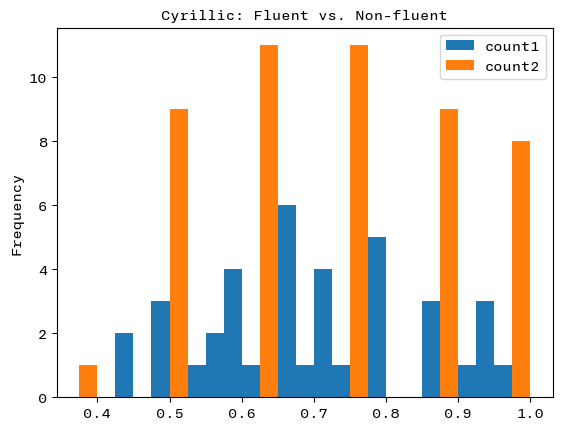

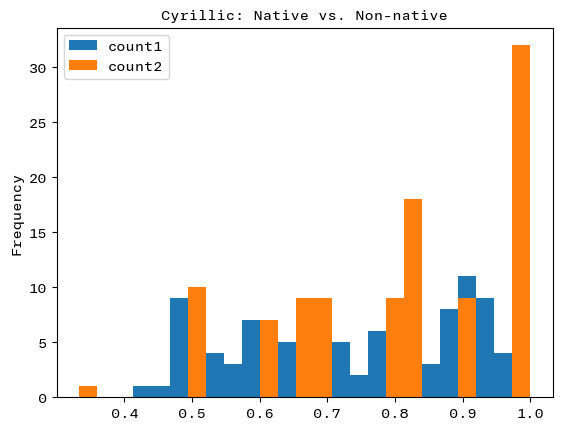

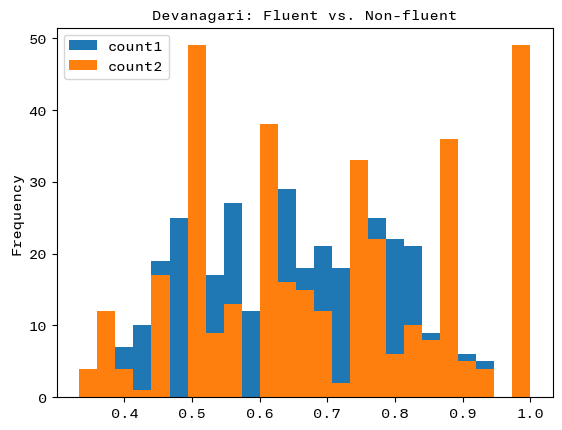

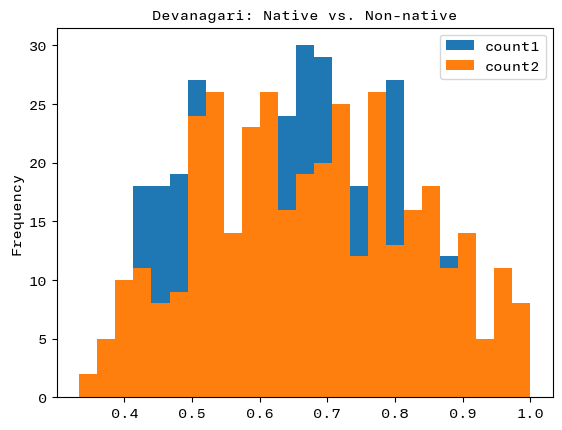

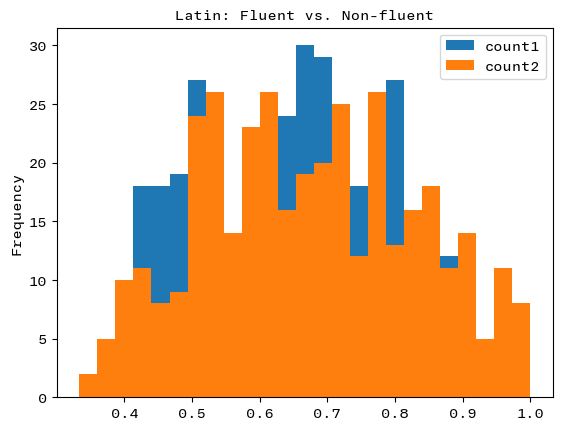

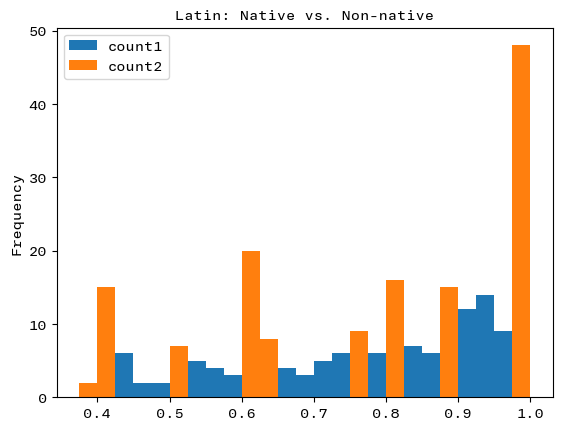

In [7]:
# Design expertise: compare between groups with hypothesis tests

results = []

try:
  _ = hypothesis_p
except:
  hypothesis_p = {script:[] for script in SCRIPTS}

for script in SCRIPTS:
  # get data for different groups
  for groupby, values in [
      ("fluent in script", (True, False)),
      ("native in script", (True, False)),
  ]:    
    row_results = {}
    # subset the tall dataset
    data1, data2 = subset_data(data, groupby, values, script)
    
    # aggregate responses to get response counts
    counts = pd.DataFrame(data1.groupby(["typeface", "triplet"])["response"].value_counts())
    counts2 = pd.DataFrame(data2.groupby(["typeface", "triplet"])["response"].value_counts())
    # combine counts from both groups into a single data frame
    counts = counts.join(counts2, how="outer", lsuffix="1", rsuffix="2", validate="one_to_one")

    # remove trials with insufficient total responses
    # get a list of all unique (typeface, triplet) combinations
    ttriplets = counts.droplevel(level="response").index.unique()
    totals = []
    for ttriplet in ttriplets:
      for s in counts.loc[ttriplet, :].sum(axis=0).values:
        if s < MIN_RESPONSE_TOTAL:
          # delete all responses for a trial with insufficient total
          for c in eval(ttriplet[1]):
            i = tuple(list(ttriplet) + [c])
            if i in counts.index:
              counts.drop(i, inplace=True)
        else:
          totals.append(s)

    # get the list of triplets again, without dropped trials
    ttriplets = counts.droplevel(level="response").index.unique()

    if len(ttriplets) >= MIN_TRIALS:
      # Mean total response count across both groups
      total_mean = pd.Series(totals).mean()

      # OOOO agreement and
      # Fisher’s Exact test for effect on triplet counts
      agreement = 0
      FET = 0
      alpha_cor = 0.013
      oooo = pd.DataFrame(index=ttriplets, columns=counts.columns)
      for ttriplet in ttriplets:
          # get all OOOO indexes for both triplet counts
          # in order to account for ties
          oooo_idx = []
          for i in [1, 2]:
            response = counts.loc[ttriplet, f"count{i}"]
            m = response.max()
            # get all indexes for max value, not just the first
            oooo_idx.append([idx for idx in response.index if response[idx] == m])
          # collect OOOO agreement and response frequencies
          # and account for ties
          if len(set(oooo_idx[0]) & set(oooo_idx[1])) > 0:
            agreement += 1
            oooo.loc[ttriplet, :] = counts.loc[ttriplet, :].max() / counts.loc[ttriplet, :].sum()
          # Fisher’s Exact test for effect on triplet counts
          tcounts = counts.loc[ttriplet, :].copy()
          # correct missing values (adds actual rows, fillna does not help)
          if len(tcounts) < 3:
            for c in eval(ttriplet[1]):
              if c not in tcounts.index:
                tcounts.loc[c, :] = 0
          _, fet_p = fisher_exact(tcounts.fillna(0).astype(int), columns=["count1", "count2"])
          if fet_p < alpha_cor:
            FET += 1
      
      # MWU hypothesis test for OOOO response frequencies
      # - using the non-parametric test as frequencies have a non-normal distribution
      # - the OOOO frequencies are also dependent
      # - the null of no difference between the distributions
      oooo = oooo.dropna().astype(np.float32)
      res = pg.mwu(oooo["count1"], oooo["count2"], alternative="two-sided")
      agreement_mwu = res.loc["MWU", "U-val"]
      agreement_p = res.loc["MWU", "p-val"]
      agreement_cles = res.loc["MWU", "CLES"]

      # Collect the hypotheses p-values for correction
      hypothesis_p[script].append(agreement_p)

      # Spearman’s rank correlation test
      # - includes r, p-unc, CI95% (confidence intervals), power
      # - the null of no correlation
      spearman = pg.pairwise_corr(counts, columns=["count1", "count2"], method="spearman")
      spearman_r = spearman["r"].iloc[0]
      spearman_p = spearman["p-unc"].iloc[0]

      row_results = {
        "Response total (mean)": f"{total_mean:.1f}",
        "OOOO %":  f"{100 * agreement / len(ttriplets):.1f} %",
        "OOOO MWU":  f"{agreement_mwu:.0f}",
        "OOOO MWU (p)":  format_small(agreement_p, p_val=True),
        "OOOO MWU (CLES)":  f"{100 * agreement_cles:.1f} %",
        "FET in % (n)":  f"{100 * FET / len(ttriplets):.1f} % ({FET:.0f})",
        "Spearman":  format_small(spearman_r),
        "Spearman p":  format_small(spearman_p, p_val=True),
      }
    # format results
    if groupby.startswith("fluent"):
      groups_nice = "Fluent vs. Non-fluent"
    elif groupby.startswith("native"):
      groups_nice = "Native vs. Non-native"
    elif groupby.startswith("design"):
      groups_nice = []
      for v in values:
        if v == DESIGNERS:
          groups_nice += ["All designers"]
        else:
          groups_nice += [f"{v}s"]  # plural of exact value
      groups_nice = " vs. ".join(groups_nice)
    
    # write only non-empty lines
    if len(ttriplets):
      row_results["Script"] = script.title()
      row_results["Groups compared"] = groups_nice
      row_results["Trials"] = f"{len(ttriplets)}"
      results.append(pd.Series(row_results, index=COLS))

    # plot to observe shape of the data
    oooo.plot(kind="hist", stacked=False, bins=25, title = f"{script.title()}: {groups_nice}")
results = pd.concat(results, axis=1).dropna(how="all").fillna("—")
display(results.T)
results.T.to_csv("csv/agreement_nativity-fluency_compared.csv")


In [8]:
# Bonferroni correction for alpha

for script in SCRIPTS:
  print(script.title())
  alpha_cor = 0.05 / len(hypothesis_p[script])
  print(f"Alpha is {alpha_cor:.3f} after Bonferroni correction.")
  for p in sorted(hypothesis_p[script]):
    if p < alpha_cor:
      significance = "reject null"
    else:
      significance = "do not reject null"
    print(f"- for p = {p:.3f} -> {significance}")

Cyrillic
Alpha is 0.013 after Bonferroni correction.
- for p = 0.000 -> reject null
- for p = 0.006 -> reject null
- for p = 0.027 -> do not reject null
- for p = 0.716 -> do not reject null
Devanagari
Alpha is 0.013 after Bonferroni correction.
- for p = 0.000 -> reject null
- for p = 0.000 -> reject null
- for p = 0.004 -> reject null
- for p = 0.019 -> do not reject null
Latin
Alpha is 0.017 after Bonferroni correction.
- for p = 0.000 -> reject null
- for p = 0.167 -> do not reject null
- for p = 0.618 -> do not reject null
